<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Optimizing ANN strategy for your Vespa application

<div class="alert alert-info">
    You probably want to be somewhat familiar with Vespa and ANN search before going through this example.<br>Recommended background reading: 
    <ul>
        <li><a href="https://docs.vespa.ai/en/nearest-neighbor-search-guide.html">Vespa nearest neighbor search - a practical guide</a></li>
        <li><a href="https://blog.vespa.ai/approximate-nearest-neighbor-search-in-vespa-part-1/">ANN Search in Vespa</a></li>
        <li><a href="https://blog.vespa.ai/constrained-approximate-nearest-neighbor-search/">Query Time Constrained Approximate Nearest Neighbor Search</a></li>
        <li><a href="https://blog.vespa.ai/additions-to-hnsw/">Additions to HNSW in Vespa: ACORN-1 and Adaptive Beam Search</a></li>
        <li><a href="https://blog.vespa.ai/tweaking-ann-parameters/">A Short Guide to Tweaking Vespa's ANN Parameters</a></li>
    </ul>
</div>    

Approximate Nearest Neighbor (ANN) search is a powerful way to make vector search scalable and efficient. In Vespa, this is implemented by building HNSW graphs for embedding fields.

## Why different strategies are needed

For a search that uses _only_ vector similarity for retrieval, this works very well for all cases, as you can just query the HNSW index and get (enough) relevant results back very fast.

However, most Vespa applications are more complex, and implement some sort of hybrid retrieval strategy, often combining vector similarity with filtering on metadata fields and/or lexical matching (weakAnd).

In this case, it is not obvious whether applying the filter first and doing an exact search will be more efficient than doing HNSW (in different variations, as we will get back to). 

The _hit-ratio_ of the filter for a given query will determine what is the most efficient strategy for the given query. 

The part that complicates this further is that the tipping point for which a strategy should be chosen is not uniform across Vespa applications, and must be tuned individually. 

This notebook will demonstrate how this tuning can be done with the recent addition of the `VespaNNParameterOptimizer` class. 

Hopefully, by stepping through this notebook, you will have learned how you can apply the same steps to tune _your_ Vespa application (configuration parameters) to get fast search responses while still maintaining acceptable recall. 

## A short note on `recall`

It is worth noting that our definition of `recall` in the context of tuning NN-parameters differs slightly from the `recall` definition used in eg. `VespaMatchEvaluator` (see https://vespa-engine.github.io/pyvespa/evaluating-vespa-application-cloud.html).

When optimizing NN-parameters, the recall will be the fraction of top K (targetHits) documents scored by exact distance that are also retrieved by the given strategy. 

This approach does not need a set of `relevant_docs`,in contrast to the `VespaMatchEvaluator`, which calculates the recall as fraction of relevant documents that are retrieved.

The good news is that a set of representative queries is all we need to tune these parameters to find the values that ensures a fast response time _and_ maintains acceptable recall across your provided queries. 

## The different strategies

With the recent addition of ACORN-1 and Adaptive Beam Search to Vespa's ANN implementation, Vespa now switches between one of the following three strategies:

1. HNSW Search with Pre-Filtering when the percentage of filtered-out documents is low,
2. HNSW Search with Pre-Filtering: Filter First/ACORN-1 when the percentage of filtered-out documents is high,
3. Exact Nearest-Neighbor Search when the percentage of filtered-out documents approaches 100%.

_When_ to switch between these three strategies is determined by a combination of a per-query internally calculated `hit-ratio` and the parameters below:

-`filter-first-exploration`: Value (in the range [0.0, 1.0]) specifying how aggressively the filter-first heuristic explores the graph when searching the HNSW graph for approximate neighbors with filtering. A higher value means that the graph is explored more aggressively and improves the recall at the cost of the response time. (Default value is 0.3.)
- `filter-first-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if the filter is checked before computing a distance (filter-first heuristic) while searching the HNSW graph for approximate neighbors with filtering. This improves the response time at low hit ratios but causes a dip in recall. The heuristic is used when the estimated filter hit ratio of the query is less than this threshold. The default value is 0.0.
- `approximate-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated by searching the HNSW graph for approximate neighbors with filtering, or performing an exact nearest neighbor search with pre-filtering. The fallback to exact search is chosen when the estimated filter hit ratio of the query is less than this threshold. The default value is 0.05.
- `post-filter-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated by searching the HNSW graph for approximate neighbors with filtering, or performing an exact nearest neighbor search with pre-filtering. The fallback to exact search is chosen when the estimated filter hit ratio of the query is less than this threshold. The default value is 0.05..

These parameters can be configured per rank profile or provided as a query parameter, which is passed with the query, and may have a big effect on query performance of queries that combines ANN search with filters.

In this notebook, we will show how to tune these parameters to ensure low response time, without losing much recall compared to exact search.

As a teaser, this is the report we will produce:
 
(Keep reading if you want to understand more)

<img alt="#ANN Optimization report" src="../_static/ann_opt_report.png" style="margin-bottom: 25px;">


Now, let us get started with the practical part. 

## The dataset

The dataset we will use for this notebook is a subset of the [GIST1M-dataset](http://corpus-texmex.irisa.fr/) commonly used for ANN benchmarks.

We have also enriched each document with a `filter`-field of type `array<int>`, that is added to each document, which allows us to construct queries with a predictable hit ratio.

Here is an example document:

```json
{
  "put": "id:test:test::499",
  "fields": {
    "id": 499,
    "filter": [1,10,50,90,95,99],
    "vec_m16": { "values": [0.01345, .., 0.30322] } // 960 float values 
  }
}
```

99% of the documents include the value 1 in the filter field, 90% of the documents include the value 10 in the fitler field and so on.

## Downloading the dataset

In [1]:
import os
import pathlib
import requests
import matplotlib.pyplot as plt
from vespa.io import VespaResponse

data_base_url = (
    "https://data.vespa-cloud.com/tests/performance/nearest-neighbor/gist-data/"
)

# We use a smaller dataset if the SCALE_DOWN flag is set to True
SCALE_DOWN = True
docs_url = (
    data_base_url + "docs.1k.json" if SCALE_DOWN else data_base_url + "docs.300k.json"
)
query_url = (
    data_base_url + "query_vectors.10.txt"
    if SCALE_DOWN
    else data_base_url + "query_vectors.100.txt"
)

In [2]:
def download_file(url: str, dest_folder: str):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


data_path = "ann_test/"
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)
docs_path = download_file(docs_url, data_path)
query_path = download_file(query_url, data_path)

## Defining the Vespa application

In [3]:
from vespa.package import (
    ApplicationPackage,
    Schema,
    Document,
    Field,
    RankProfile,
    HNSW,
    DocumentSummary,
    Summary,
)
from vespa.configuration.query_profiles import query_profile, query_profile_type, field


# Define the document with fields
doc = Document(
    fields=[
        Field(
            name="id",
            type="int",
            indexing=["attribute", "summary"],
        ),
        Field(
            name="filter",
            type="array<int>",  # This is our filter field
            indexing=["attribute", "summary"],
            attribute=["fast-search"],
        ),
        Field(
            name="vec_m16",
            type="tensor<float>(x[960])",  # The vector field that we will do ANN search on
            indexing=["attribute", "index", "summary"],
            ann=HNSW(
                distance_metric="euclidean",  # specific to this dataset
                max_links_per_node=16,  #
                neighbors_to_explore_at_insert=500,  # Specifies how many neighbors to explore when inserting a vector in the HNSW graph. The default value in Vespa is 200. This parameter is called efConstruction in the HNSW paper.
            ),
        ),
    ]
)

# Define the rank profile with HNSW tuning parameters
rank_profile = RankProfile(
    name="default",
    inputs=[
        ("query(q_vec)", "tensor<float>(x[960])"),
    ],
    first_phase="closeness(label,nns)",
    # We will tune some of these by overriding them as query parameters later
    rank_properties=[
        ("approximate-threshold", 0.05),
        ("filter-first-threshold", 0.0),
        ("filter-first-exploration", 0.3),
        ("exploration-slack", 0.0),
    ],
)

# Define a minimal document summary to avoid unnecessary data transfer
minimal_summary = DocumentSummary(name="minimal", summary_fields=[Summary(name="id")])

# Create the schema
schema = Schema(
    name="test",
    document=doc,
    rank_profiles=[rank_profile],
    document_summaries=[minimal_summary],
)

# We also define a query profile type for the default query profile to enforce the type of the input tensor
# See https://docs.vespa.ai/en/query-profiles.html#query-profile-types
qp = query_profile(
    id="default",
    type="root",
)

qpt = query_profile_type(
    field(
        name="ranking.features.query(q_vec)",
        type="tensor<float>(x[960])",
    ),
    id="root",
    inherits="native",
)

# Create the application package
app_package = ApplicationPackage(
    name="test", schema=[schema], query_profile_config=[qp, qpt]
)

<query-profile-type id="root" inherits="native">
  <field name="ranking.features.query(q_vec)" type="tensor&lt;float&gt;(x[960])" />
</query-profile-type>

<query-profile id="default" type="root" />

It is often useful to dump the application package to files for inspection before deploying. 

In [4]:
app_package.to_files("ann_test")

In [5]:
from vespa.deployment import VespaDocker
from vespa.application import Vespa

vespa_docker = VespaDocker()
app: Vespa = vespa_docker.deploy(app_package)

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Waiting for application to come up, 10/300 seconds.
Application is up!
Finished deployment.
Application is up!
Finished deployment.


## Feeding the documents

In [6]:
# Load and feed documents
import json

with open(docs_path, "r") as f:
    docs = json.load(f)

docs_formatted = [
    {
        "id": str(doc["fields"]["id"]),
        "fields": doc["fields"],
    }
    for doc in docs
]

In [7]:
print(len(docs_formatted))

1000


In [8]:
def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print("Id " + id + " + failed : " + response.json)


app.feed_iterable(docs_formatted)

## Constructing queries

We will use the [Querybuilder API](/query.html#using-the-querybuilder-dsl-api) to construct our queries.

In [9]:
import vespa.querybuilder as qb


def vector_to_query(vec_str: str, filter_value: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("test")
            .where(
                qb.nearestNeighbor(
                    "vec_m16",
                    "q_vec",
                    annotations={
                        "targetHits": 100,
                        "approximate": True,
                        "label": "nns",
                    },
                )
                & (qb.QueryField("filter") == filter_value),
            )
        ),
        "hits": 10,
        "presentation.summary": "minimal",
        "timeout": "20s",
        "ranking.features.query(q_vec)": vec_str.strip(),
    }

In [10]:
with open(query_path, "r") as f:
    query_vectors = f.readlines()

# Filter values
filter_percentage = [1, 10, 50, 90, 95, 99]

# We will construct queries for each combination of query vector and filter value
queries = []
# We will also construct a single query per filter value for hit ratio evaluation
# The vector does not affect the hit ratio, so it is overkill to run a query for each vector
# just to determine the hit ratio
hitratio_queries = []  # will only have one query per filter value, choosing the last vector arbitrarily
for filter_value in filter_percentage:
    for vec in query_vectors:
        queries.append(vector_to_query(vec, filter_value))
    hitratio_queries.append(queries[-1])
print(len(queries), len(hitratio_queries))

60 6


Let us now run a test query against our Vespa app.

In [11]:
resp = app.query(queries[0])
resp.json

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 100},
  'coverage': {'coverage': 100,
   'documents': 300000,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'index:test_content/0/546939e47e504db66440d8a4',
    'relevance': 0.5514919500458465,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 81360}},
   {'id': 'index:test_content/0/9e6b6ea9a292297d51985c1a',
    'relevance': 0.5493186760384602,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 284987}},
   {'id': 'index:test_content/0/33ae6c85890ab031dfc63566',
    'relevance': 0.548701224770975,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 238816}},
   {'id': 'index:test_content/0/355d6a2ae889c1554b5d241f',
    'relevance': 0.5464117465305897,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 222086}},
   {'id': 'index:test_content/0/989ef83d04f54e0ecb2a2f69',
    'releva

## How `VespaNNParameterOptimizer.run()` Works

The `run()` method orchestrates the entire optimization process through a structured sequence of steps. Each step builds upon the results of previous steps to determine optimal parameter values.

### Sequential Optimization Process

**Step 1: Distribute queries to buckets based on filter hit ratios**
   - The optimizer first determines the hit ratio for each query by examining how many documents pass through the filter
   - Queries are then sorted into buckets representing small intervals of hit ratios (controlled by the `buckets_per_percent` parameter)
   - This bucketing allows the optimizer to analyze performance characteristics across the full spectrum of filtering selectivity

**Step 2: Validate query coverage across different hit ratio ranges**
   - The optimizer checks that queries are present across key hit ratio intervals: [0.0-0.25), [0.25-0.50), [0.50-0.75), [0.75-0.90), [0.90-0.95), and [0.95-1.0)
   - It also verifies that non-empty buckets contain a sufficient number of queries (at least 10) to ensure statistical significance
   - If coverage is insufficient, warnings are issued, though optimization continues

**Step 3: Optimize filterFirstExploration** (first parameter)
   - Controls how aggressively the filter-first heuristic explores the HNSW graph when searching for approximate neighbors with filtering
   - Value range: [0.0, 1.0] — higher values improve recall at the cost of response time
   - The optimizer tests multiple exploration values and measures both response time and recall for queries in each bucket
   - Finds the value that best balances response time increase against recall improvement using binary search (typically 7 iterations)
   - Default value is 0.3

**Step 4: Optimize filterFirstThreshold** (second parameter, uses filterFirstExploration from Step 3)
   - Determines when to apply the filter-first heuristic while searching the HNSW graph
   - Value range: [0.0, 1.0] — the heuristic is used when the estimated filter hit ratio is *less than* this threshold
   - Benchmarks two strategies: HNSW-only vs Filter-First (using the optimized exploration value)
   - Identifies the threshold where Filter-First becomes beneficial by comparing response times across buckets
   - Lower hit ratios benefit from checking the filter before computing distances
   - Default value is 0.0 (disabled)

**Step 5: Optimize approximateThreshold** (third parameter, uses filterFirstThreshold and filterFirstExploration from Steps 3-4)
   - Decides when to fall back to exact nearest neighbor search instead of approximate HNSW search
   - Value range: [0.0, 1.0] — exact search is chosen when the estimated filter hit ratio is *less than* this threshold
   - Compares exact search performance against ANN search with the tuned filter-first parameters
   - Identifies buckets where exact search is faster than ANN, working backwards from high selectivity
   - Helps avoid poor performance when filters are highly selective
   - Default value is 0.05

**Step 6: Optimize postFilterThreshold** (fourth parameter, uses all previous parameters)
   - Determines when to use post-filtering instead of the default pre-filtering strategy
   - Value range: [0.0, 1.0] — post-filtering is chosen when the estimated filter hit ratio is *larger than* this threshold
   - Compares post-filtering vs pre-filtering (with all tuned parameters) on both response time and recall
   - Finds the optimal threshold that maximizes response time gain without significant recall loss (less than 1% drop)
   - With post-filtering, targetHits is auto-adjusted to expose enough hits after filtering
   - Default value is 1.0 (disabled)

**Step 7: Return comprehensive report**
   - Suggested values for all four parameters
   - Benchmark results (response times) for different configurations tested
   - Recall measurements showing quality tradeoffs
   - Query distribution across hit ratio buckets

## Establishing the baseline searchtime and recall

Before we start, let's set a baseline for the searchtime and recall, using Vespa's default parameters.

In [36]:
from vespa.evaluation import VespaNNParameterOptimizer
import numpy as np

# Create a new optimizer instance for step-by-step execution
before_opt = VespaNNParameterOptimizer(
    app=app, queries=queries, hits=100, buckets_per_percent=2, print_progress=True
)

# Step 1: Distribute queries to buckets
print("Step 1: Distributing queries to buckets based on hit ratios...")
before_opt.determine_hit_ratios_and_distribute_to_buckets(queries)

# Step 2: Validate coverage
print("\nStep 2: Validating query coverage...")
sufficient = before_opt.has_sufficient_queries()
buckets_filled = before_opt.buckets_sufficiently_filled()

print(f"  Sufficient query coverage: {sufficient}")
print(f"  Buckets sufficiently filled: {buckets_filled}")
print(f"  Total queries: {before_opt.get_number_of_queries()}")
print(f"  Non-empty buckets: {before_opt.get_number_of_nonempty_buckets()}")
benchmark_before = before_opt.benchmark()
mean_searchtime_before = np.mean(benchmark_before.y)
print("Average search time before optimization: ")
print(f"{mean_searchtime_before:.2f} ms")
recall_per_bucket_before = before_opt.compute_average_recalls()
avg_recall_before = np.mean(recall_per_bucket_before.y)
print("Average recall before optimization: ")
print(f"{avg_recall_before:.4f}")

Step 1: Distributing queries to buckets based on hit ratios...

Step 2: Validating query coverage...
  No queries found with filtered-out ratio in [0.25,0.5)
  Sufficient query coverage: False
  Buckets sufficiently filled: True
  Total queries: 60
  Non-empty buckets: 6
  Benchmarking: 100.0%
Average search time before optimization: 
6.02 ms
  Benchmarking: 100.0%.67%
Average search time before optimization: 
6.02 ms
  Computing recall: 100.0%
Average recall before optimization: 
0.9228
  Computing recall: 100.0%
Average recall before optimization: 
0.9228


In [12]:
from vespa.evaluation import VespaNNParameterOptimizer

optimizer = VespaNNParameterOptimizer(
    app=app, queries=queries, hits=100, buckets_per_percent=2, print_progress=True
)
report = optimizer.run()

  No queries found with filtered-out ratio in [0.25,0.5)
Determining suggestion for filterFirstExploration
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.5
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.25
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.375
  Computing recall: 100.0%
  Testing 0.375
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.4375
  Computing recall: 100.0%
  Testing 0.4375
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.46875
  Computing recall: 100.0%
  Testing 0.46875
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.453125
  Computing r

## Running the Complete Optimization with run()

Now let's see how all these steps can be executed together using the `run()` method:

### Step 1 & 2: Distribute Queries and Validate Coverage

- The optimizer first determines the hit ratio for each query by examining how many documents pass through the filter
- Queries are then sorted into buckets representing small intervals of hit ratios (controlled by the `buckets_per_percent` parameter)
- This bucketing allows the optimizer to analyze performance characteristics across the full spectrum of filtering selectivity

In [13]:
# Create a new optimizer instance for step-by-step execution
step_optimizer = VespaNNParameterOptimizer(
    app=app, queries=queries, hits=100, buckets_per_percent=2, print_progress=True
)

# Step 1: Distribute queries to buckets
print("Step 1: Distributing queries to buckets based on hit ratios...")
step_optimizer.determine_hit_ratios_and_distribute_to_buckets(queries)

# Step 2: Validate coverage
print("\nStep 2: Validating query coverage...")
sufficient = step_optimizer.has_sufficient_queries()
buckets_filled = step_optimizer.buckets_sufficiently_filled()

print(f"  Sufficient query coverage: {sufficient}")
print(f"  Buckets sufficiently filled: {buckets_filled}")
print(f"  Total queries: {step_optimizer.get_number_of_queries()}")
print(f"  Non-empty buckets: {step_optimizer.get_number_of_nonempty_buckets()}")

Step 1: Distributing queries to buckets based on hit ratios...

Step 2: Validating query coverage...
  No queries found with filtered-out ratio in [0.25,0.5)
  Sufficient query coverage: False
  Buckets sufficiently filled: True
  Total queries: 60
  Non-empty buckets: 6

Step 2: Validating query coverage...
  No queries found with filtered-out ratio in [0.25,0.5)
  Sufficient query coverage: False
  Buckets sufficiently filled: True
  Total queries: 60
  Non-empty buckets: 6


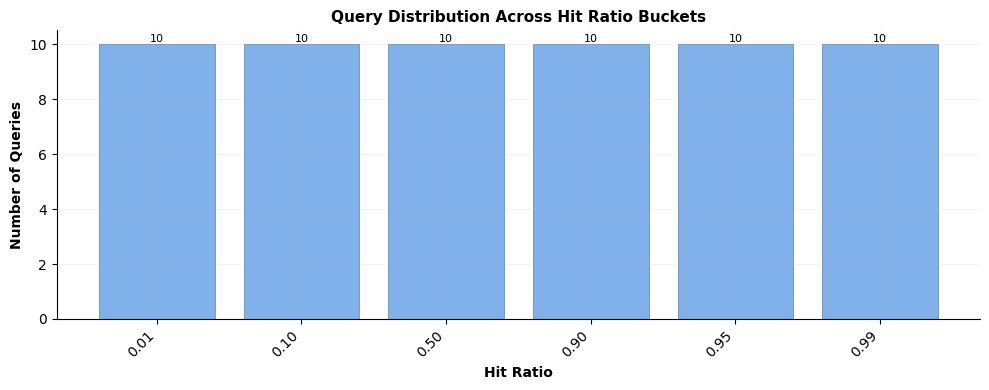

In [14]:
# Visualize query distribution
x, y = step_optimizer.get_query_distribution()
hit_ratios = [hr * 100 for hr in x]  # Convert to percentage for plotting

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(x)), y, color="#4A90E2", alpha=0.7, edgecolor="#2E5C8A", linewidth=0.5)
ax.set_xlabel("Hit Ratio", fontsize=10, fontweight="bold")
ax.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
ax.set_title(
    "Query Distribution Across Hit Ratio Buckets", fontsize=11, fontweight="bold"
)
ax.set_xticks(range(len(x)))
ax.set_xticklabels([f"{val:.2f}" for val in x], rotation=45, ha="right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.2, linewidth=0.5)

for i, height in enumerate(y):
    ax.text(i, height, str(int(height)), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

### Step 3: Optimize filterFirstExploration

In [15]:
print("Step 3: Optimizing filterFirstExploration...")
ffe_report = step_optimizer.suggest_filter_first_exploration()
filter_first_exploration = ffe_report["suggestion"]

print(f"\nSuggested filterFirstExploration: {filter_first_exploration:.4f}")

Step 3: Optimizing filterFirstExploration...
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.5
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.25
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.375
  Computing recall: 100.0%
  Testing 0.375
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.3125
  Computing recall: 100.0%
  Testing 0.3125
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.28125
  Computing recall: 100.0%
  Testing 0.28125
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Testing 0.265625
  Computing recall: 100.0%
  Testing 0.265625
  Benchmarking: 100.0%
  Benc

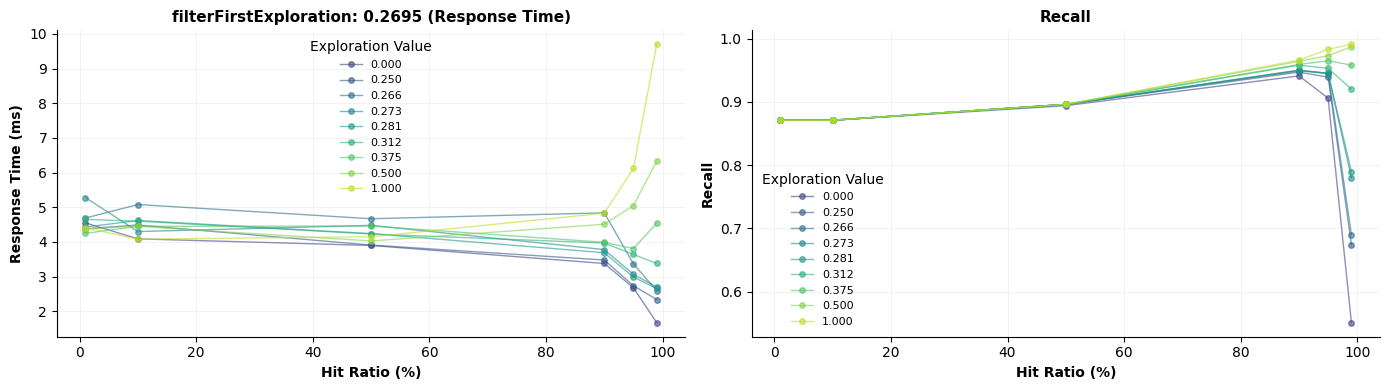

In [16]:
# Visualize filterFirstExploration optimization
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Get exploration values from the report
exploration_values = sorted([k for k in ffe_report["benchmarks"].keys()])
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

# Response Time plot
for i, exp_val in enumerate(exploration_values):
    benchmarks = ffe_report["benchmarks"][exp_val]
    label = f"{exp_val:.3f}"
    if abs(exp_val - filter_first_exploration) < 0.001:
        label += " ✓"
        ax1.plot(
            hit_ratios,
            benchmarks,
            "o-",
            color=colors[i],
            linewidth=2,
            markersize=6,
            label=label,
            zorder=10,
        )
    else:
        ax1.plot(
            hit_ratios,
            benchmarks,
            "o-",
            color=colors[i],
            linewidth=1,
            markersize=4,
            alpha=0.6,
            label=label,
        )

ax1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax1.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
ax1.set_title(
    f"filterFirstExploration: {filter_first_exploration:.4f} (Response Time)",
    fontsize=11,
    fontweight="bold",
)
ax1.legend(fontsize=8, frameon=False, loc="best", title="Exploration Value")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(True, alpha=0.2, linewidth=0.5)

# Recall plot
recall_measurements = ffe_report["recall_measurements"]
for i, exp_val in enumerate(exploration_values):
    recalls = recall_measurements[exp_val]
    label = f"{exp_val:.3f}"
    if abs(exp_val - filter_first_exploration) < 0.001:
        label += " ✓"
        ax2.plot(
            hit_ratios,
            recalls,
            "o-",
            color=colors[i],
            linewidth=2,
            markersize=6,
            label=label,
            zorder=10,
        )
    else:
        ax2.plot(
            hit_ratios,
            recalls,
            "o-",
            color=colors[i],
            linewidth=1,
            markersize=4,
            alpha=0.6,
            label=label,
        )

ax2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax2.set_ylabel("Recall", fontsize=10, fontweight="bold")
ax2.set_title("Recall", fontsize=11, fontweight="bold")
ax2.legend(fontsize=8, frameon=False, loc="best", title="Exploration Value")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

### Step 4: Optimize filterFirstThreshold

In [17]:
print("Step 4: Optimizing filterFirstThreshold...")
fft_report = step_optimizer.suggest_filter_first_threshold(
    **{"ranking.matching.filterFirstExploration": filter_first_exploration}
)
filter_first_threshold = fft_report["suggestion"]

print(f"\nSuggested filterFirstThreshold: {filter_first_threshold:.4f}")

Step 4: Optimizing filterFirstThreshold...
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%

Suggested filterFirstThreshold: 0.4750
  Benchmarking: 100.0%

Suggested filterFirstThreshold: 0.4750


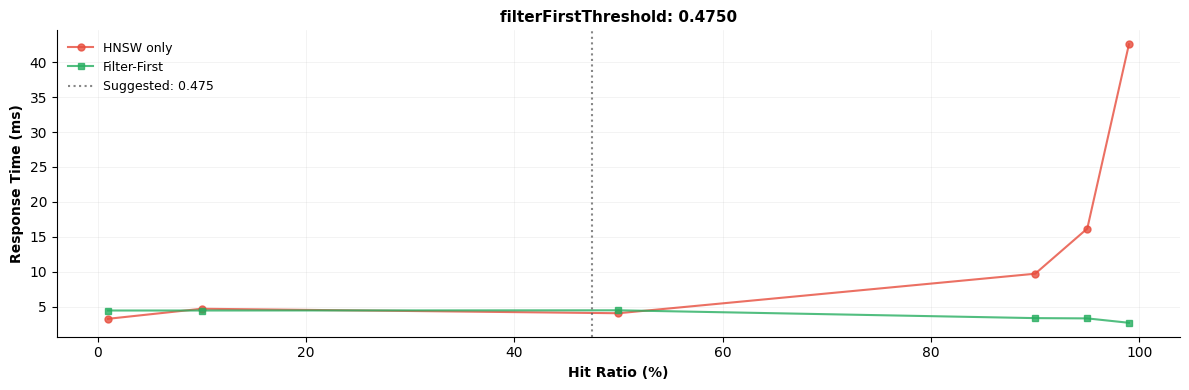

In [18]:
# Visualize filterFirstThreshold optimization
fig, ax = plt.subplots(figsize=(12, 4))

benchmarks_hnsw = fft_report["benchmarks"]["hnsw"]
benchmarks_ff = fft_report["benchmarks"]["filter_first"]

ax.plot(
    hit_ratios,
    benchmarks_hnsw,
    "o-",
    color="#E74C3C",
    linewidth=1.5,
    markersize=5,
    label="HNSW only",
    alpha=0.8,
)
ax.plot(
    hit_ratios,
    benchmarks_ff,
    "s-",
    color="#27AE60",
    linewidth=1.5,
    markersize=5,
    label="Filter-First",
    alpha=0.8,
)
ax.axvline(
    x=filter_first_threshold * 100,
    color="#555",
    linestyle=":",
    linewidth=1.5,
    label=f"Suggested: {filter_first_threshold:.3f}",
    alpha=0.7,
)

ax.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
ax.set_title(
    f"filterFirstThreshold: {filter_first_threshold:.4f}",
    fontsize=11,
    fontweight="bold",
)
ax.legend(fontsize=9, frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

### Step 5: Optimize approximateThreshold

In [19]:
print("Step 5: Optimizing approximateThreshold...")
at_report = step_optimizer.suggest_approximate_threshold(
    **{
        "ranking.matching.filterFirstThreshold": filter_first_threshold,
        "ranking.matching.filterFirstExploration": filter_first_exploration,
    }
)
approximate_threshold = at_report["suggestion"]

print(f"\nSuggested approximateThreshold: {approximate_threshold:.4f}")

Step 5: Optimizing approximateThreshold...
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%

Suggested approximateThreshold: 0.0150
  Benchmarking: 100.0%

Suggested approximateThreshold: 0.0150


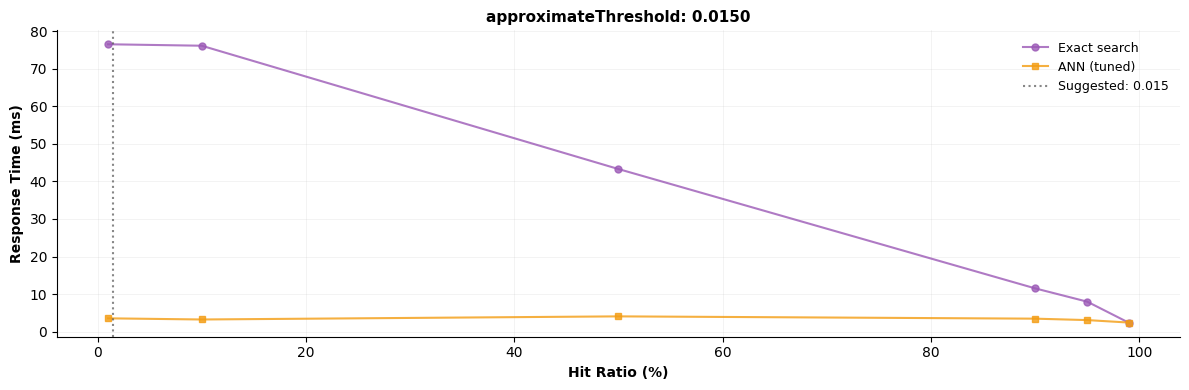

In [20]:
# Visualize approximateThreshold optimization
fig, ax = plt.subplots(figsize=(12, 4))

benchmarks_exact = at_report["benchmarks"]["exact"]
benchmarks_ann = at_report["benchmarks"]["filter_first"]

ax.plot(
    hit_ratios,
    benchmarks_exact,
    "o-",
    color="#9B59B6",
    linewidth=1.5,
    markersize=5,
    label="Exact search",
    alpha=0.8,
)
ax.plot(
    hit_ratios,
    benchmarks_ann,
    "s-",
    color="#F39C12",
    linewidth=1.5,
    markersize=5,
    label="ANN (tuned)",
    alpha=0.8,
)
ax.axvline(
    x=approximate_threshold * 100,
    color="#555",
    linestyle=":",
    linewidth=1.5,
    label=f"Suggested: {approximate_threshold:.3f}",
    alpha=0.7,
)

ax.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
ax.set_title(
    f"approximateThreshold: {approximate_threshold:.4f}", fontsize=11, fontweight="bold"
)
ax.legend(fontsize=9, frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

### Step 6: Optimize postFilterThreshold

In [21]:
print("Step 6: Optimizing postFilterThreshold...")
pft_report = step_optimizer.suggest_post_filter_threshold(
    **{
        "ranking.matching.approximateThreshold": approximate_threshold,
        "ranking.matching.filterFirstThreshold": filter_first_threshold,
        "ranking.matching.filterFirstExploration": filter_first_exploration,
    }
)
post_filter_threshold = pft_report["suggestion"]

print(f"\nSuggested postFilterThreshold: {post_filter_threshold:.4f}")

Step 6: Optimizing postFilterThreshold...
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%.67%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Computing recall: 100.0%

Suggested postFilterThreshold: 0.4850
  Computing recall: 100.0%

Suggested postFilterThreshold: 0.4850


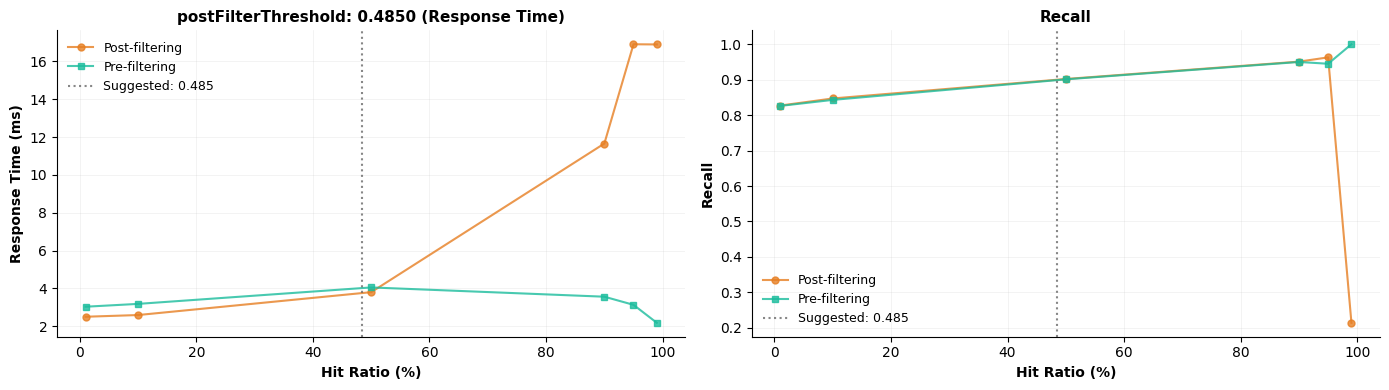

In [22]:
# Visualize postFilterThreshold optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

benchmarks_post = pft_report["benchmarks"]["post_filtering"]
benchmarks_pre = pft_report["benchmarks"]["filter_first"]
recall_post = pft_report["recall_measurements"]["post_filtering"]
recall_pre = pft_report["recall_measurements"]["filter_first"]

# Response time comparison
ax1.plot(
    hit_ratios,
    benchmarks_post,
    "o-",
    color="#E67E22",
    linewidth=1.5,
    markersize=5,
    label="Post-filtering",
    alpha=0.8,
)
ax1.plot(
    hit_ratios,
    benchmarks_pre,
    "s-",
    color="#1ABC9C",
    linewidth=1.5,
    markersize=5,
    label="Pre-filtering",
    alpha=0.8,
)
ax1.axvline(
    x=post_filter_threshold * 100,
    color="#555",
    linestyle=":",
    linewidth=1.5,
    label=f"Suggested: {post_filter_threshold:.3f}",
    alpha=0.7,
)

ax1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax1.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
ax1.set_title(
    f"postFilterThreshold: {post_filter_threshold:.4f} (Response Time)",
    fontsize=11,
    fontweight="bold",
)
ax1.legend(fontsize=9, frameon=False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(True, alpha=0.2, linewidth=0.5)

# Recall comparison
ax2.plot(
    hit_ratios,
    recall_post,
    "o-",
    color="#E67E22",
    linewidth=1.5,
    markersize=5,
    label="Post-filtering",
    alpha=0.8,
)
ax2.plot(
    hit_ratios,
    recall_pre,
    "s-",
    color="#1ABC9C",
    linewidth=1.5,
    markersize=5,
    label="Pre-filtering",
    alpha=0.8,
)
ax2.axvline(
    x=post_filter_threshold * 100,
    color="#555",
    linestyle=":",
    linewidth=1.5,
    label=f"Suggested: {post_filter_threshold:.3f}",
    alpha=0.7,
)

ax2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
ax2.set_ylabel("Recall", fontsize=10, fontweight="bold")
ax2.set_title("Recall", fontsize=11, fontweight="bold")
ax2.legend(fontsize=9, frameon=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

### Step 7: Summary of Optimized Parameters

In [23]:
print("=" * 60)
print("OPTIMIZATION COMPLETE - SUGGESTED PARAMETERS")
print("=" * 60)
print(f"filterFirstExploration:  {filter_first_exploration:.4f} (default: 0.3)")
print(f"filterFirstThreshold:    {filter_first_threshold:.4f} (default: 0.0)")
print(f"approximateThreshold:    {approximate_threshold:.4f} (default: 0.05)")
print(f"postFilterThreshold:     {post_filter_threshold:.4f} (default: 1.0)")
print("=" * 60)

OPTIMIZATION COMPLETE - SUGGESTED PARAMETERS
filterFirstExploration:  0.2695 (default: 0.3)
filterFirstThreshold:    0.4750 (default: 0.0)
approximateThreshold:    0.0150 (default: 0.05)
postFilterThreshold:     0.4850 (default: 1.0)


## Visualize Optimization Results

Let's create a comprehensive visualization of the optimization report to better understand the recommendations.

In [24]:
from typing import Dict, Any, Tuple
import numpy as np


def plot_optimization_report(
    report: Dict[str, Any], figsize: Tuple[int, int] = (18, 12)
) -> plt.Figure:
    """
    Create a comprehensive visualization of the VespaNNParameterOptimizer report.

    This function creates a Tufte-inspired multi-panel plot showing parameters in the
    order they are calculated:
    1. filterFirstExploration (response time + recall)
    2. filterFirstThreshold (response time comparison)
    3. approximateThreshold (response time comparison)
    4. postFilterThreshold (response time + recall)

    Args:
        report: The report dictionary generated by VespaNNParameterOptimizer.run()
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Extract data
    buckets = report["buckets"]
    hit_ratios = np.array(buckets["hit_ratios"]) * 100  # Convert to percentage
    query_distribution = buckets["query_distribution"]

    # Create figure with subplots organized by parameter
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        4, 3, hspace=0.4, wspace=0.3, top=0.94, bottom=0.05, left=0.06, right=0.97
    )

    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Row 0: Query Distribution + Summary Table
    # 1. Query Distribution (top left, spans 2 columns)
    ax_dist = fig.add_subplot(gs[0, 0:2])

    # Use evenly spaced x-positions for bars
    x_positions = np.arange(len(hit_ratios))
    _bars = ax_dist.bar(
        x_positions,
        query_distribution,
        width=0.7,
        color="#4A90E2",
        alpha=0.7,
        edgecolor="#2E5C8A",
        linewidth=0.5,
    )

    ax_dist.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_dist.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
    ax_dist.set_title(
        "Query Distribution Across Hit Ratios", fontsize=11, fontweight="bold", pad=10
    )
    ax_dist.set_xticks(x_positions)
    ax_dist.set_xticklabels([f"{hr:.1f}" for hr in hit_ratios], rotation=0)
    setup_tufte_axes(ax_dist)

    # Add value labels on bars
    for i, (x_pos, height) in enumerate(zip(x_positions, query_distribution)):
        ax_dist.text(
            x_pos, height, f"{int(height)}", ha="center", va="bottom", fontsize=8
        )

    # 2. Summary Table (top right)
    ax_summary = fig.add_subplot(gs[0, 2])
    ax_summary.axis("off")

    summary_data = [
        ["Parameter", "Suggested"],
        ["", ""],
        [
            "filterFirstExploration",
            f"{report['filterFirstExploration']['suggestion']:.4f}",
        ],
        ["filterFirstThreshold", f"{report['filterFirstThreshold']['suggestion']:.4f}"],
        ["approximateThreshold", f"{report['approximateThreshold']['suggestion']:.4f}"],
        ["postFilterThreshold", f"{report['postFilterThreshold']['suggestion']:.4f}"],
        ["", ""],
        ["Total Queries", f"{sum(query_distribution)}"],
        ["Number of buckets", f"{len(buckets)}"],
        ["Buckets per %", f"{buckets['buckets_per_percent']}"],
    ]

    table = ax_summary.table(
        cellText=summary_data,
        cellLoc="left",
        loc="center",
        colWidths=[0.65, 0.35],
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Style the table
    for i, row in enumerate(summary_data):
        for j in range(len(row)):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor("#34495E")
                cell.set_text_props(weight="bold", color="white", size=8)
            elif i == 1 or i == 6:  # Separator rows
                cell.set_facecolor("#ECF0F1")
                cell.set_height(0.02)
            elif i >= 7:  # Info section
                cell.set_facecolor("#F8F9FA")
            else:
                cell.set_facecolor("white")
            cell.set_edgecolor("#BDC3C7")
            cell.set_linewidth(0.5)

    ax_summary.set_title("Summary", fontsize=11, fontweight="bold", pad=10, loc="left")

    # Row 1: filterFirstExploration (calculated first)
    # Response Time
    ax_ffe_rt = fig.add_subplot(gs[1, 0:2])
    ffe_data = report["filterFirstExploration"]
    ffe_suggestion = ffe_data["suggestion"]

    exploration_values = sorted([k for k in ffe_data["benchmarks"].keys()])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

    for i, exp_val in enumerate(exploration_values):
        benchmarks = ffe_data["benchmarks"][exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_rt.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_title(
        f"1. filterFirstExploration: {ffe_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_ffe_rt.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_rt)

    # Recall
    ax_ffe_recall = fig.add_subplot(gs[1, 2])
    recall_measurements = ffe_data["recall_measurements"]

    for i, exp_val in enumerate(exploration_values):
        recalls = recall_measurements[exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_recall.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_ffe_recall.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_recall)

    # Row 2: filterFirstThreshold (calculated second)
    ax_fft = fig.add_subplot(gs[2, :])
    fft_data = report["filterFirstThreshold"]
    fft_suggestion = fft_data["suggestion"]

    benchmarks_hnsw = fft_data["benchmarks"]["hnsw"]
    benchmarks_ff = fft_data["benchmarks"]["filter_first"]

    ax_fft.plot(
        hit_ratios,
        benchmarks_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft.plot(
        hit_ratios,
        benchmarks_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_fft.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_fft.set_title(
        f"2. filterFirstThreshold: {fft_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_fft.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_fft)

    # Row 3: approximateThreshold (calculated third) + postFilterThreshold Response Time (calculated fourth)
    # approximateThreshold
    ax_at = fig.add_subplot(gs[3, 0:2])
    at_data = report["approximateThreshold"]
    at_suggestion = at_data["suggestion"]

    benchmarks_exact = at_data["benchmarks"]["exact"]
    benchmarks_ann = at_data["benchmarks"]["filter_first"]

    ax_at.plot(
        hit_ratios,
        benchmarks_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at.plot(
        hit_ratios,
        benchmarks_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_at.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_at.set_title(
        f"3. approximateThreshold: {at_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_at.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_at)

    # postFilterThreshold - Recall only (Response Time would be redundant with recall tradeoff)
    ax_pft = fig.add_subplot(gs[3, 2])
    pft_data = report["postFilterThreshold"]
    pft_suggestion = pft_data["suggestion"]

    recall_post = pft_data["recall_measurements"]["post_filtering"]
    recall_pre = pft_data["recall_measurements"]["filter_first"]

    ax_pft.plot(
        hit_ratios,
        recall_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft.plot(
        hit_ratios,
        recall_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )

    # Add suggestion line
    ax_pft.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_pft.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_pft.set_title(
        f"4. postFilterThreshold: {pft_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_pft.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_pft)

    # Overall title
    fig.suptitle(
        "Vespa NN Parameter Optimization Report (Calculation Order)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    return fig

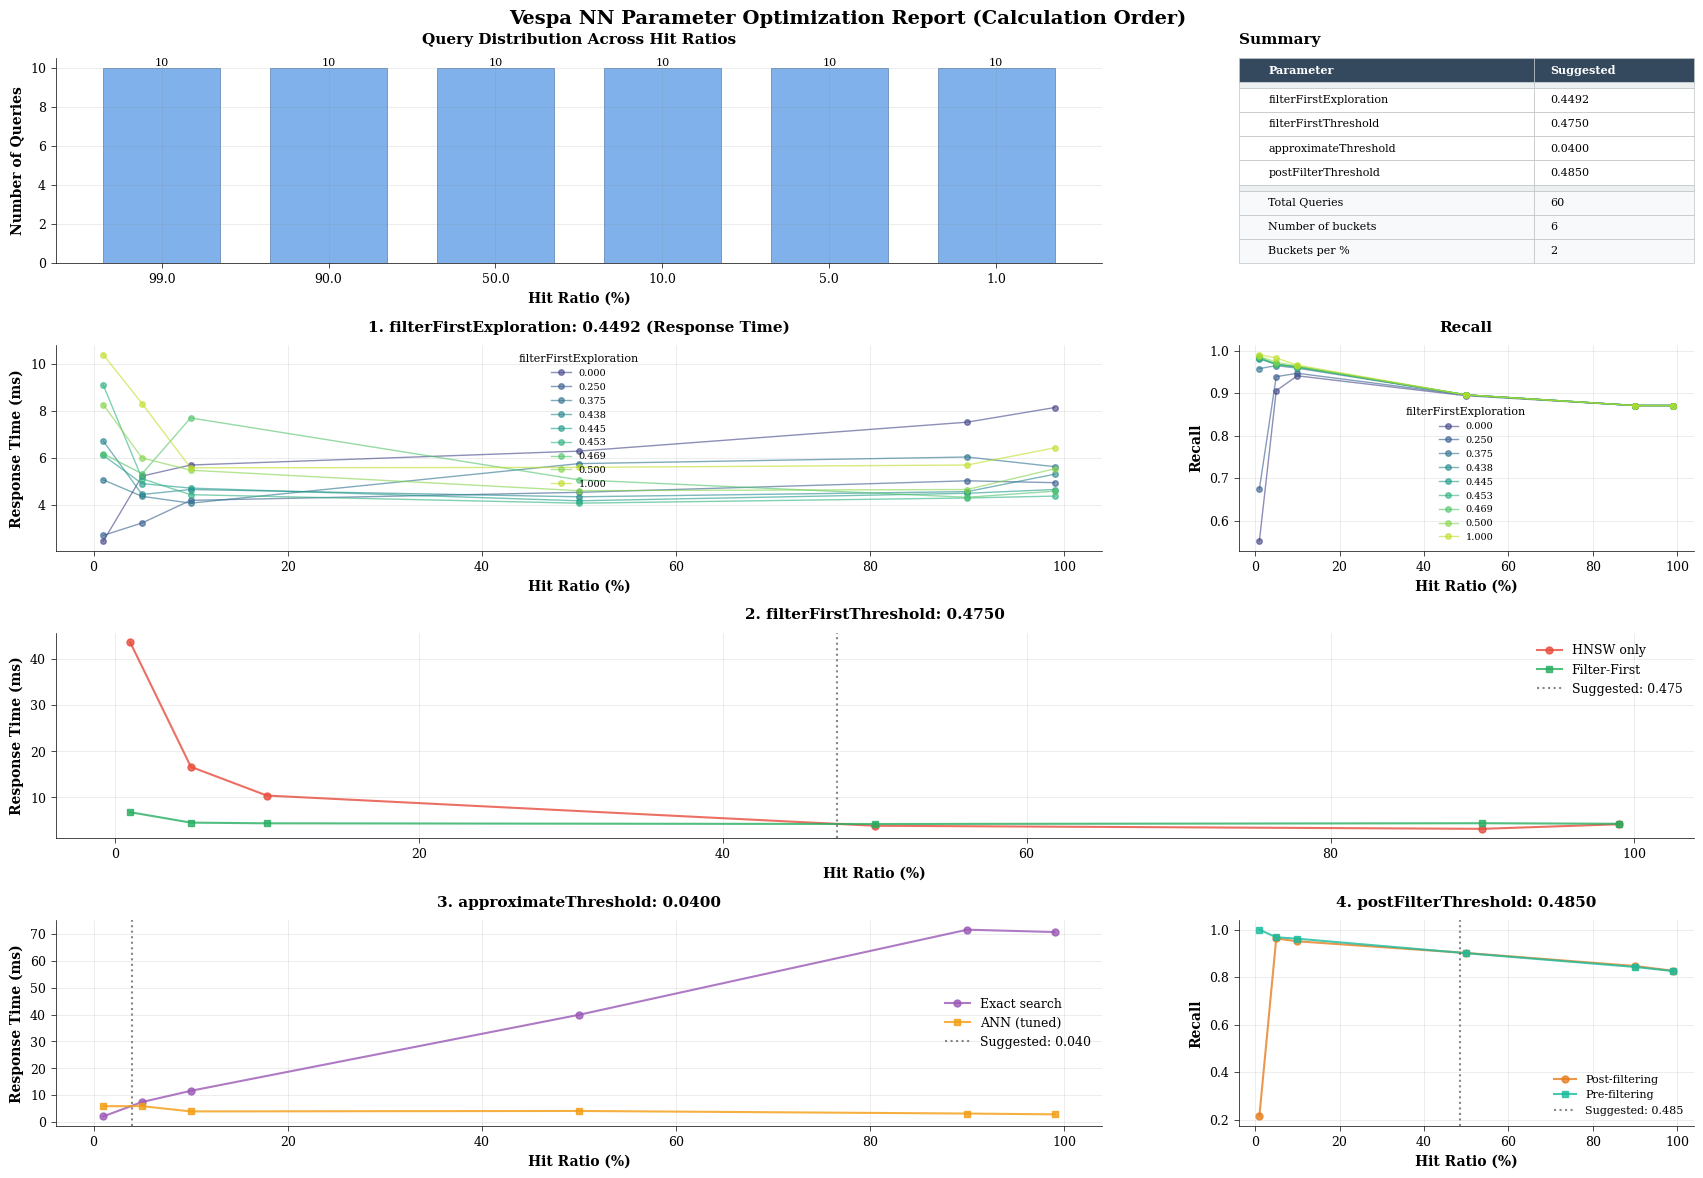

In [25]:
# Generate the visualization
fig = plot_optimization_report(report, figsize=(18, 12))
plt.show()

## Check if we improved



In [38]:
print("=" * 60)
print("OPTIMIZATION COMPLETE - SUGGESTED PARAMETERS")
print("=" * 60)
print(f"filterFirstExploration:  {filter_first_exploration:.4f} (default: 0.3)")
print(f"filterFirstThreshold:    {filter_first_threshold:.4f} (default: 0.0)")
print(f"approximateThreshold:    {approximate_threshold:.4f} (default: 0.05)")
print(f"postFilterThreshold:     {post_filter_threshold:.4f} (default: 1.0)")
print("=" * 60)

optimized_params = {
    "ranking.matching.filterFirstExploration": filter_first_exploration,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.approximateThreshold": approximate_threshold,
    "ranking.matching.postFilterThreshold": post_filter_threshold,
}

OPTIMIZATION COMPLETE - SUGGESTED PARAMETERS
filterFirstExploration:  0.2695 (default: 0.3)
filterFirstThreshold:    0.4750 (default: 0.0)
approximateThreshold:    0.0150 (default: 0.05)
postFilterThreshold:     0.4850 (default: 1.0)


In [39]:
from vespa.evaluation import VespaNNParameterOptimizer
import numpy as np

# Create a new optimizer instance for step-by-step execution
after_opt = VespaNNParameterOptimizer(
    app=app, queries=queries, hits=100, buckets_per_percent=2, print_progress=True
)

# Step 1: Distribute queries to buckets
print("Step 1: Distributing queries to buckets based on hit ratios...")
after_opt.determine_hit_ratios_and_distribute_to_buckets(queries)

# Step 2: Validate coverage
print("\nStep 2: Validating query coverage...")
sufficient = after_opt.has_sufficient_queries()
buckets_filled = after_opt.buckets_sufficiently_filled()

print(f"  Sufficient query coverage: {sufficient}")
print(f"  Buckets sufficiently filled: {buckets_filled}")
print(f"  Total queries: {after_opt.get_number_of_queries()}")
print(f"  Non-empty buckets: {after_opt.get_number_of_nonempty_buckets()}")
benchmark_after = after_opt.benchmark(**optimized_params)
mean_searchtime_after = np.mean(benchmark_after.y)
print("Average search time after optimization: ")
print(f"{mean_searchtime_after:.2f} ms")
recall_per_bucket_after = after_opt.compute_average_recalls(**optimized_params)
avg_recall_after = np.mean(recall_per_bucket_after.y)
print("Average recall after optimization: ")
print(f"{avg_recall_after:.4f}")

Step 1: Distributing queries to buckets based on hit ratios...

Step 2: Validating query coverage...
  No queries found with filtered-out ratio in [0.25,0.5)
  Sufficient query coverage: False
  Buckets sufficiently filled: True
  Total queries: 60
  Non-empty buckets: 6
->Benchmarking: 0.0%
Step 2: Validating query coverage...
  No queries found with filtered-out ratio in [0.25,0.5)
  Sufficient query coverage: False
  Buckets sufficiently filled: True
  Total queries: 60
  Non-empty buckets: 6
  Benchmarking: 100.0%
Average search time after optimization: 
5.99 ms
  Benchmarking: 100.0%.67%
Average search time after optimization: 
5.99 ms
  Computing recall: 100.0%
Average recall after optimization: 
0.9118
  Computing recall: 100.0%
Average recall after optimization: 
0.9118


### Understanding the Visualization

The visualization displays parameters in the **order they are calculated** (each depending on previous ones):

**Row 0: Overview**
- **Query Distribution**: Shows how queries are distributed across hit ratio percentages
- **Summary Table**: All suggested parameter values at a glance

**Row 1: filterFirstExploration** (calculated first)
- **Response Time**: Compares different exploration values. Suggested value (✓) balances speed vs recall.
- **Recall**: Shows recall tradeoff for each exploration value

**Row 2: filterFirstThreshold** (calculated second, uses filterFirstExploration)
- Compares HNSW-only vs Filter-First strategies
- Vertical line shows suggested threshold where Filter-First becomes beneficial

**Row 3: approximateThreshold & postFilterThreshold** (calculated third and fourth)
- **approximateThreshold**: When to use exact search vs ANN search
- **postFilterThreshold**: Recall comparison between post-filtering and pre-filtering strategies

**Key improvements:**
- X-axis shows **Hit Ratio (%)** instead of bucket index for easier interpretation
- Parameters are **grouped** (response time + recall together)
- **Sequential order** matches the calculation dependencies
- Tufte-inspired design: minimal ink, clear annotations, direct comparisons

## Parameter Optimization

Now we'll optimize the HNSW parameters for our queries. This process will:
1. Determine hit ratios for queries
2. Optimize `filterFirstExploration` by collecting resp
3. Optimize `filterFirstThreshold`
4. Optimize `approximateThreshold`
5. Optimize `postFilterThreshold`
6. Compare current vs suggested settings

When constructing your own query set for tuning these values, you should make sure that the queries are representative for _your_ query load. As this might be difficult to predict in advance, it might also be wise to ensure that you have some queries with filters that have both large and small hit ratios, to ensure that also these type of queries would perform well with your application. 

### Step 1: Determine Hit Ratios

You might question why we want to find out the hit ratios, as we previously stated that we knew them. 

Consider the more common case where you do not know the hit ratio in advance, and you see that this is a necessary prerequisite step in order to tune your parameters.